In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
import pandas as pd
import json

# Read-in the data

In [ ]:
# 0. Connect your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/INLS613/
!ls # special shell command to view the files in the home directory of the notebook environment

# 0.1 load in train and test jsonl objects and combined them into a list of json elements
df_list = []

def load_in(file_name):
    with open(file_name, 'r') as json_file:
        json_list = list(json_file)

    # 0.2 transfer json_objects into a pd df

    for json_str in json_list:
        result = json.loads(json_str)
        df = pd.DataFrame()
        for col in result:
            if str(col) == "players" or str(col) == "game_id":
                continue
            temp_list = []
            for entry in result[col]:
                temp_list.append(entry)
            df[col] = pd.Series(temp_list)
        df_list.append(df)

load_in('train.jsonl')
load_in('test.jsonl')

df = pd.concat(df_list, ignore_index = True)
df = df.dropna()

print(df.head())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1HDQBolrZEf9kEk3BtM9CoA6nCG47BqqG/INLS613
 combined.csv			 test.jsonl
'Final Presentation.gslides'	 TODO.gdoc
 nb_results			 train.jsonl
'Project Proposal.gdoc'		 train_scrubbedMinusEmotes.csv
'Project Proposal_Graded.docx'	 train_scrubbedMinusEmotes.gsheet
'Project Report.gdoc'		 wordcloud_all.png
'Test Final Project (1).gdoc'	 wordcloud_lie.png
'Test Final Project (1).pdf'	 wordcloud_truth.png
'Test Final Project.ipynb'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


                                            messages  sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...            1.0   
1  You've whet my appetite, Italy. What's the sug...            1.0   
2                                                  👍            1.0   
3  It seems like there are a lot of ways that cou...            1.0   
4  Yeah, I can’t say I’ve tried it and it works, ...            1.0   

  receiver_labels speakers receivers  absolute_message_index  \
0            True    italy   germany                    74.0   
1            True  germany     italy                    76.0   
2            True    italy   germany                    86.0   
3            True  germany     italy                    87.0   
4    NOANNOTATION    italy   germany                    89.0   

   relative_message_index seasons years game_score game_score_delta  
0                     0.0  Spring  1901          3                0  
1                     1.0  Spring  1901         

## Removing ineffective feature columns


In [ ]:
#import pandas as pd
#df = pd.read_csv("train_scrubbedMinusEmotes.csv")
#df=df.drop(columns=['Unnamed: 0','Unnamed: 12', 'Unnamed: 13','Unnamed: 14','seasons','years','speakers','receivers','receiver_labels'])
df = df.drop(columns=['seasons','years','speakers','receivers'])
df.head()

messages  sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...            1.0   
1  You've whet my appetite, Italy. What's the sug...            1.0   
2                                                  👍            1.0   
3  It seems like there are a lot of ways that cou...            1.0   
4  Yeah, I can’t say I’ve tried it and it works, ...            1.0   

  receiver_labels  absolute_message_index  relative_message_index game_score  \
0            True                    74.0                     0.0          3   
1            True                    76.0                     1.0          3   
2            True                    86.0                     2.0          3   
3            True                    87.0                     3.0          3   
4    NOANNOTATION                    89.0                     4.0          3   

  game_score_delta  
0                0  
1                0  
2                0  
3                0  
4                0

## Calculate Sender Accuracy and prec (overall)



> Indented block



In [ ]:
def human_test(df):
  true_all = 0
  total = 0

  true_lie = 0
  false_lie = 0
  for i, row in df.iterrows():
    r_lab = row["receiver_labels"]
    if r_lab == "NOANNOTATION":
      continue
    else:
      if bool(row['sender_labels']) == row['receiver_labels']:
        true_all += 1
    total += 1
    if bool(row['sender_labels']) == False and row['receiver_labels'] == False:
      true_lie += 1
    if bool(row['sender_labels']) == False and row['receiver_labels'] == True:
      false_lie += 1

  accuracy_receiver_total = true_all / total
  print(f"The accuracy for humans is: {accuracy_receiver_total}")

  prec_receiver_total = true_lie / (true_lie + false_lie)
  print(f"The precision for humans is: {prec_receiver_total}")
  prec_receiver_total

human_test(df)

The accuracy for humans is: 0.9124827586206896
The precision for humans is: 0.1422872340425532


# Feature Generation

## Gather all the 'False' class and downsampling the 'True' class for a total sample size of 1662 (50-50 split)

In [ ]:
false=df[df['sender_labels']==False]
false

messages  sender_labels  \
132    I really don’t think that’s a fair description...            0.0   
135    We’re friends, right? I believe that every sin...            0.0   
139    I have to say that I’m surprised that you feel...            0.0   
144     Here’s the deal: I like you better than England.            0.0   
158    But I don’t think there is anything wrong with...            0.0   
...                                                  ...            ...   
15836  You are obviously not allied with Italy. I don...            0.0   
15847  He's angry at me- so not sure how helpful he w...            0.0   
15851  I think the point where I stop making any prog...            0.0   
15861                 There's no solo in sight right now            0.0   
15868  Interesting, I didn't mean to take Naples- I f...            0.0   

      receiver_labels  absolute_message_index  relative_message_index  \
132              True                  1517.0                   132.0   
135              True                  1521.0                   135.0   
139              True                  1535.0                   139.0   
144              True                  1548.0                   144.0   
158              True                  1582.0                   158.0   
...               ...                     ...                     ...   
15836            True                  1210.0                    50.0   
15847            True                  1260.0                    61.0   
15851            True                  1327.0                    65.0   
15861           False                  1419.0                    75.0   
15868            True                  1498.0                    82.0   

      game_score game_score_delta  
132            8                3  
135            8                3  
139            8                3  
144            8                3  
158            8                3  
...          ...              ...  
15836          9                4  
15847         12                6  
15851         12                6  
15861         15                8  
15868         15                8  

[831 rows x 7 columns]

In [ ]:
true=df[df['sender_labels']==True]
true = true.sample(n = false.shape[0], random_state=1)
true

messages  sender_labels  \
5700                             You're not doing badly!            1.0   
12361  I was definitely thinking of going after Franc...            1.0   
4472   I mean... I could be interested but I need som...            1.0   
11894  God if only you knew how complicated things ar...            1.0   
1729           I am. And it stays between us, of course.            1.0   
...                                                  ...            ...   
6683   Helping Italy with Piedmont. You're probably f...            1.0   
2823   I mean, you may already be thinking this, but ...            1.0   
12348                       Not sure what you mean there            1.0   
11123                                  God the Turks ugh            1.0   
3811   What did he agree to do?  Asking so I can hold...            1.0   

      receiver_labels  absolute_message_index  relative_message_index  \
5700             True                  1231.0                    55.0   
12361    NOANNOTATION                    28.0                     2.0   
4472             True                  2445.0                   379.0   
11894            True                  1123.0                    83.0   
1729             True                  2043.0                   440.0   
...               ...                     ...                     ...   
6683     NOANNOTATION                   788.0                    30.0   
2823     NOANNOTATION                  1577.0                   205.0   
12348            True                   482.0                    47.0   
11123            True                  1353.0                   299.0   
3811     NOANNOTATION                  1423.0                    77.0   

      game_score game_score_delta  
5700           5                0  
12361          3                0  
4472           9                1  
11894          6                1  
1729           7                2  
...          ...              ...  
6683           4                0  
2823           5               -2  
12348          4               -2  
11123          7                2  
3811           4               -1  

[831 rows x 7 columns]

In [ ]:
final = true.append(false)
final = final.reset_index(drop=True)
final = final.sample(frac=1)
final

messages  sender_labels  \
941            What do you think about E/I/R as a trio?            0.0   
1179                     That seems fair enough, I'm in            0.0   
1194                      Alright I'll go for that then            0.0   
476   So... the thing is, their going to have to cho...            1.0   
289   Update on Italy - they just told me that they ...            1.0   
...                                                 ...            ...   
90                           Yup.  Okay, gotta run now.            1.0   
1561  Would you be willing to support Tunis to the I...            0.0   
340   You ask for the pause? Good work on holding of...            1.0   
1502  And I hate to be so greedy to open up but I'm ...            0.0   
867   I will avoid taking Portugal, vacate Tyrolia, ...            0.0   

     receiver_labels  absolute_message_index  relative_message_index  \
941             True                  1656.0                   227.0   
1179            True                   130.0                     5.0   
1194            True                   272.0                    25.0   
476             True                   283.0                     6.0   
289             True                    82.0                    14.0   
...              ...                     ...                     ...   
90              True                   228.0                    39.0   
1561    NOANNOTATION                  1424.0                    82.0   
340             True                  2686.0                    20.0   
1502            True                   232.0                    35.0   
867             True                  2211.0                   282.0   

     game_score game_score_delta  
941           8                3  
1179          3                0  
1194          7                0  
476           3                0  
289           3                0  
...         ...              ...  
90            5                1  
1561         15               13  
340           8                6  
1502          3                0  
867          10                3  

[1662 rows x 7 columns]

### Get Human Metrics for Sample

In [ ]:
final_sender = final
human_test(final_sender)
final = final.drop(columns=["receiver_labels"])
final

The accuracy for humans is: 0.5459387483355526
The precision for humans is: 0.1422872340425532


messages  sender_labels  \
941            What do you think about E/I/R as a trio?            0.0   
1179                     That seems fair enough, I'm in            0.0   
1194                      Alright I'll go for that then            0.0   
476   So... the thing is, their going to have to cho...            1.0   
289   Update on Italy - they just told me that they ...            1.0   
...                                                 ...            ...   
90                           Yup.  Okay, gotta run now.            1.0   
1561  Would you be willing to support Tunis to the I...            0.0   
340   You ask for the pause? Good work on holding of...            1.0   
1502  And I hate to be so greedy to open up but I'm ...            0.0   
867   I will avoid taking Portugal, vacate Tyrolia, ...            0.0   

      absolute_message_index  relative_message_index game_score  \
941                   1656.0                   227.0          8   
1179                   130.0                     5.0          3   
1194                   272.0                    25.0          7   
476                    283.0                     6.0          3   
289                     82.0                    14.0          3   
...                      ...                     ...        ...   
90                     228.0                    39.0          5   
1561                  1424.0                    82.0         15   
340                   2686.0                    20.0          8   
1502                   232.0                    35.0          3   
867                   2211.0                   282.0         10   

     game_score_delta  
941                 3  
1179                0  
1194                0  
476                 0  
289                 0  
...               ...  
90                  1  
1561               13  
340                 6  
1502                0  
867                 3  

[1662 rows x 6 columns]

Flip Sender Values

In [ ]:
#Now need to flip the sender_labels to use precision values. Lies are now postive case

for i, row in final.iterrows():
  if row["sender_labels"] == 0.0:
    final.at[i,"sender_labels"] = 1.0
  else:
    final.at[i,"sender_labels"] = 0.0

final.head()

messages  sender_labels  \
941            What do you think about E/I/R as a trio?            1.0   
1179                     That seems fair enough, I'm in            1.0   
1194                      Alright I'll go for that then            1.0   
476   So... the thing is, their going to have to cho...            0.0   
289   Update on Italy - they just told me that they ...            0.0   

      absolute_message_index  relative_message_index game_score  \
941                   1656.0                   227.0          8   
1179                   130.0                     5.0          3   
1194                   272.0                    25.0          7   
476                    283.0                     6.0          3   
289                     82.0                    14.0          3   

     game_score_delta  
941                 3  
1179                0  
1194                0  
476                 0  
289                 0

##Adding Psycholinguistic features

In [ ]:
#Initalizing various lists 
import nltk
nltk.download('opinion_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')


#use opinion lexicion from NLTK for sentiment 
sense_words = set(['see', 'sense', 'appearance', 'smell', 'bittersweet', 'dull', 
               'dim', 'gloomy', 'grand', 'bright', 'dismal', 'massive', 'neat', 
               'pop', 'tear', 'cry', 'deaf', 'murmur', 'explode', 'hush', 
               'firm', 'rocky', 'cold', 'solid', 'narrow', 'delicate', 'stale', 
               'sweaty', 'robust', 'delicious', 'tempting', 'replusive', 
               'appealing', 'appetizing', 'tantalizing', 'spoiled'])
motion_words = set(['arrive', 'run', 'walk', 'move', 'attack', 'defend', 'claim', 
                'capture', 'hold', 'sprint', 'sail', 'maneuver', 'advance', 
                'retreat', 'go'])    
exclusion_words = set(['but', 'without', 'exclude', 'except', 'only', 'just', 
                   'either'])
self_reference_words = set(['i', 'me', 'my', 'mine', 'we', 'ours'])
hesitations_words = set(['um', 'er', 'uh', 'hmm', 'ah'])
hedge_words = set(['perhaps', 'maybe', 'admittedly', 'might', 'possibly', 'likely', 
               'probably', 'predominantly', 'presumably', 'seems', 'appears', 
               'may', 'suggests', 'sometimes', 'often', 'around', 'roughly', 
               'fairly', 'usually'])
negation_words = set(['never', 'no', 'nothing', 'nowhere', 'noone', 'none', 'not', 
                  'havent', 'hasnt', 'hadnt', 'cant', 'couldnt', 'shouldnt', 
                  'wont', 'wouldnt', 'dont', 'doesnt', 'didnt', 'isnt', 'arent',
                  'aint'])
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())
#negation_words -- pull from NLTK sentiment ult 

psycholing_features = final


psycholing_features.head()

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


messages  sender_labels  \
941            What do you think about E/I/R as a trio?            1.0   
1179                     That seems fair enough, I'm in            1.0   
1194                      Alright I'll go for that then            1.0   
476   So... the thing is, their going to have to cho...            0.0   
289   Update on Italy - they just told me that they ...            0.0   

      absolute_message_index  relative_message_index game_score  \
941                   1656.0                   227.0          8   
1179                   130.0                     5.0          3   
1194                   272.0                    25.0          7   
476                    283.0                     6.0          3   
289                     82.0                    14.0          3   

     game_score_delta  
941                 3  
1179                0  
1194                0  
476                 0  
289                 0

In [ ]:
from collections import Counter
import string


for i, row in psycholing_features.iterrows():
  sense_words_count = 0
  pos_words_count = 0
  neg_words_count = 0
  motion_words_count = 0
  exclusion_words_count = 0
  self_reference_words_count = 0
  hesitations_words_count = 0
  hedge_words_count = 0
  negation_words_count = 0
  words_greater_six_count = 0
  
  message = row["messages"]
  message = message.lower()
  message = message.translate(str.maketrans('', '', string.punctuation)) #remove punc
  message = message.split()
  message_unique = list(set(message))
  if len(message) > 0:
    message_TTR = len(message_unique) / len(message) # calcuate type token ratio
  else:
    message_TTR = 0

  for word in message:
    if word in pos_words:
      pos_words_count += 1
    elif word in neg_words:
      neg_words_count += 1
    if word in sense_words: # will refactor to look nice
      sense_words_count += 1
    if word in motion_words:
      motion_words_count += 1
    if word in exclusion_words:
      exclusion_words_count += 1
    if word in self_reference_words:
      self_reference_words_count += 1
    if word in hesitations_words:
      hesitations_words_count += 1
    if word in hedge_words:
      hedge_words_count += 1
    if word in negation_words:
      negation_words_count += 1
    if len(word) > 6:
      words_greater_six_count += 1

  tokens = message
  text = nltk.Text(tokens)
  tagged_text = nltk.pos_tag(text, tagset='universal')
  counts = Counter(tag for word,tag in tagged_text) # get count of each part of speech found

  psycholing_features.at[i, "positive_word_count"] = pos_words_count  #will refactor later to look nice
  psycholing_features.at[i,"negative_word_count"] = neg_words_count
  psycholing_features.at[i,"sense_words_count"] = sense_words_count
  psycholing_features.at[i,"motion_words_count"] = motion_words_count
  psycholing_features.at[i,"exclusion_words_count"] = exclusion_words_count
  psycholing_features.at[i,"self_reference_words_count"] = self_reference_words_count
  psycholing_features.at[i,"hesitations_words_count"] = hesitations_words_count
  psycholing_features.at[i,"hedge_words_count"] = hedge_words_count
  psycholing_features.at[i,"negation_words_count"] = negation_words_count
  psycholing_features.at[i,"words_greater_six_count"] = words_greater_six_count
  psycholing_features.at[i,"TTR"] = message_TTR
  psycholing_features.at[i,"pronoun_count"] = counts["PRON"]
  psycholing_features.at[i,"adjective_count"] = counts["ADJ"]
  psycholing_features.at[i,"noun_count"] = counts["NOUN"]
  psycholing_features.at[i,"verb_count"] = counts["VERB"]
  psycholing_features.at[i,"conjuction_count"] = counts["CONJ"]
  psycholing_features.at[i,"preposition_count"] = counts["ADP"]
  psycholing_features.at[i,"adverb_count"] = counts["ADV"]

psycholing_features.head()

messages  sender_labels  \
941            What do you think about E/I/R as a trio?            1.0   
1179                     That seems fair enough, I'm in            1.0   
1194                      Alright I'll go for that then            1.0   
476   So... the thing is, their going to have to cho...            0.0   
289   Update on Italy - they just told me that they ...            0.0   

      absolute_message_index  relative_message_index game_score  \
941                   1656.0                   227.0          8   
1179                   130.0                     5.0          3   
1194                   272.0                    25.0          7   
476                    283.0                     6.0          3   
289                     82.0                    14.0          3   

     game_score_delta  positive_word_count  negative_word_count  \
941                 3                  0.0                  0.0   
1179                0                  2.0                  0.0   
1194                0                  0.0                  0.0   
476                 0                  0.0                  1.0   
289                 0                  1.0                  0.0   

      sense_words_count  motion_words_count  ...  negation_words_count  \
941                 0.0                 0.0  ...                   0.0   
1179                0.0                 0.0  ...                   0.0   
1194                0.0                 1.0  ...                   0.0   
476                 0.0                 1.0  ...                   0.0   
289                 0.0                 0.0  ...                   1.0   

      words_greater_six_count       TTR  pronoun_count  adjective_count  \
941                       0.0  1.000000            2.0              0.0   
1179                      0.0  1.000000            0.0              1.0   
1194                      1.0  1.000000            0.0              0.0   
476                       9.0  0.780488            1.0              3.0   
289                       4.0  0.868421            5.0              3.0   

      noun_count  verb_count  conjuction_count  preposition_count  \
941          1.0         2.0               0.0                1.0   
1179         1.0         1.0               0.0                1.0   
1194         2.0         1.0               0.0                1.0   
476         11.0        12.0               2.0                5.0   
289          7.0         9.0               0.0                6.0   

      adverb_count  
941            2.0  
1179           1.0  
1194           1.0  
476            2.0  
289            2.0  

[5 rows x 24 columns]

In [ ]:
psycholing_features = psycholing_features.drop(columns=["messages", 'absolute_message_index', "sender_labels", "relative_message_index", "game_score", "game_score_delta"])
psycholing_features.head()

positive_word_count  negative_word_count  sense_words_count  \
941                   0.0                  0.0                0.0   
1179                  2.0                  0.0                0.0   
1194                  0.0                  0.0                0.0   
476                   0.0                  1.0                0.0   
289                   1.0                  0.0                0.0   

      motion_words_count  exclusion_words_count  self_reference_words_count  \
941                  0.0                    0.0                         0.0   
1179                 0.0                    0.0                         0.0   
1194                 1.0                    0.0                         0.0   
476                  1.0                    0.0                         3.0   
289                  0.0                    1.0                         2.0   

      hesitations_words_count  hedge_words_count  negation_words_count  \
941                       0.0                0.0                   0.0   
1179                      0.0                1.0                   0.0   
1194                      0.0                0.0                   0.0   
476                       0.0                0.0                   0.0   
289                       0.0                1.0                   1.0   

      words_greater_six_count       TTR  pronoun_count  adjective_count  \
941                       0.0  1.000000            2.0              0.0   
1179                      0.0  1.000000            0.0              1.0   
1194                      1.0  1.000000            0.0              0.0   
476                       9.0  0.780488            1.0              3.0   
289                       4.0  0.868421            5.0              3.0   

      noun_count  verb_count  conjuction_count  preposition_count  \
941          1.0         2.0               0.0                1.0   
1179         1.0         1.0               0.0                1.0   
1194         2.0         1.0               0.0                1.0   
476         11.0        12.0               2.0                5.0   
289          7.0         9.0               0.0                6.0   

      adverb_count  
941            2.0  
1179           1.0  
1194           1.0  
476            2.0  
289            2.0

## Apply TF-IDF vectorizer

### Generate stop word dictionary specific to the dataset

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df_sw = pd.read_csv("train_scrubbedMinusEmotes.csv")
speaker_unique = df_sw['speakers'].unique()
stop = stopwords.words('english') + speaker_unique.tolist()
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Apply TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(ngram_range=(1,1),stop_words=stop)
text = v.fit_transform(final['messages'])

text_rep = pd.DataFrame(text.toarray(), columns=v.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Combining all the features repersentation configurations and target together

In [ ]:
final_drop=final.drop(columns=['messages'])
combined = pd.concat([text_rep, psycholing_features, final_drop], axis=1,join='inner')
TFIDF_psycho = pd.concat([text_rep, psycholing_features], axis=1,join='inner')
psycho_final = pd.concat([psycholing_features, final_drop], axis=1,join='inner')
TFIDF_final = pd.concat([text_rep, final_drop], axis=1,join='inner')

#combined.head()
#TFIDF_psycho.head()
psycho_final.head()
#TFIDF_final.head()
configuations = [combined, TFIDF_psycho, psycho_final, TFIDF_final]

# Exploratory Data Analysis

## Word cloud using data from both target class

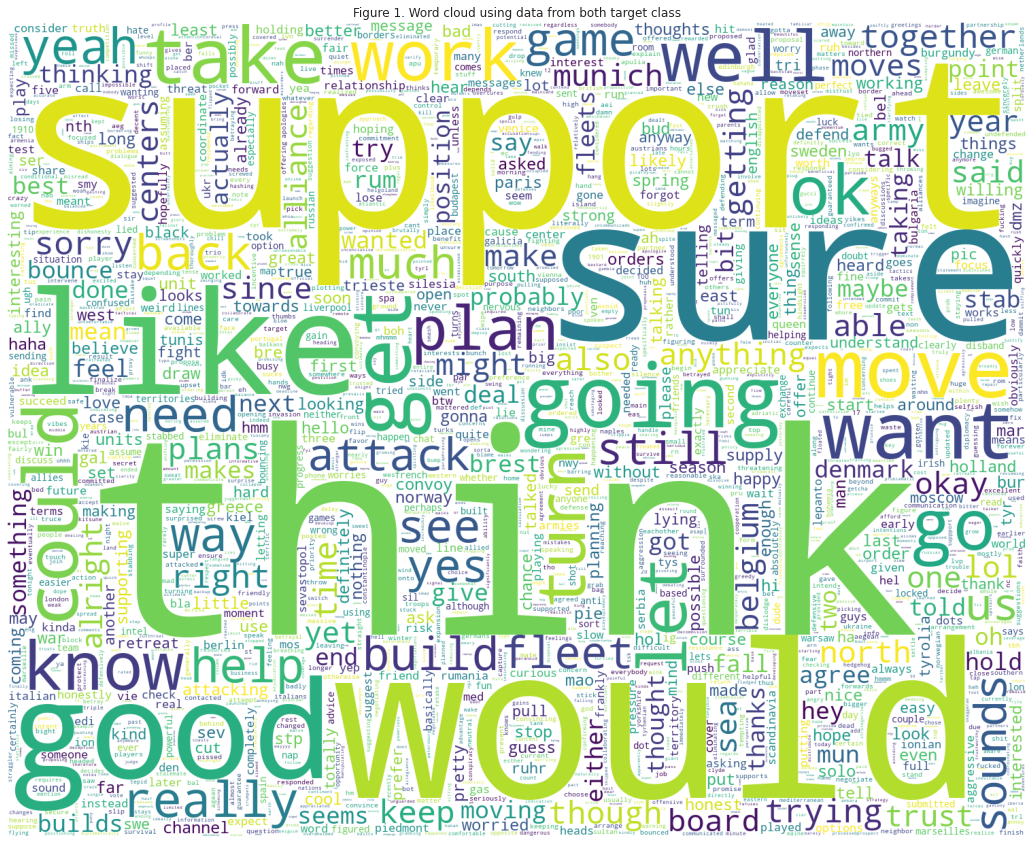

In [ ]:
#v.vocabulary_.items()
tfidf_weights = [(word, text.getcol(idx).sum()) for word, idx in v.vocabulary_.items()]
#tfidf_weights[0:10]
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.title("Figure 1. Word cloud using data from both target class")
plt.savefig('wordcloud_all.png')

## Word cloud for truth only

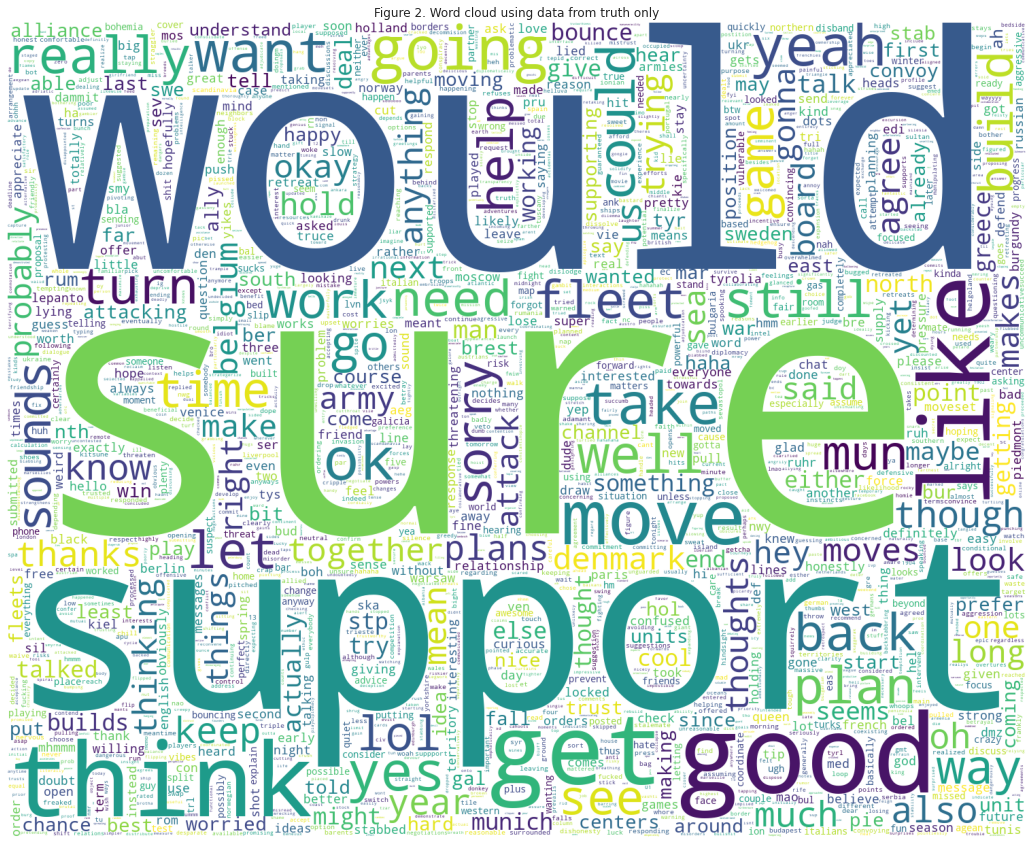

In [ ]:
v_t = TfidfVectorizer(ngram_range=(1,1),stop_words=stop)
text_t = v_t.fit_transform(true['messages'])

tfidf_weights_t = [(word, text_t.getcol(idx).sum()) for word, idx in v_t.vocabulary_.items()]

w_t = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights_t))
plt.figure(figsize=(20,15))
plt.imshow(w_t)
plt.axis('off')
plt.title("Figure 2. Word cloud using data from truth only")
plt.savefig('wordcloud_truth.png')


In [ ]:
combined.to_csv("combined.csv")

## Word cloud for lie only

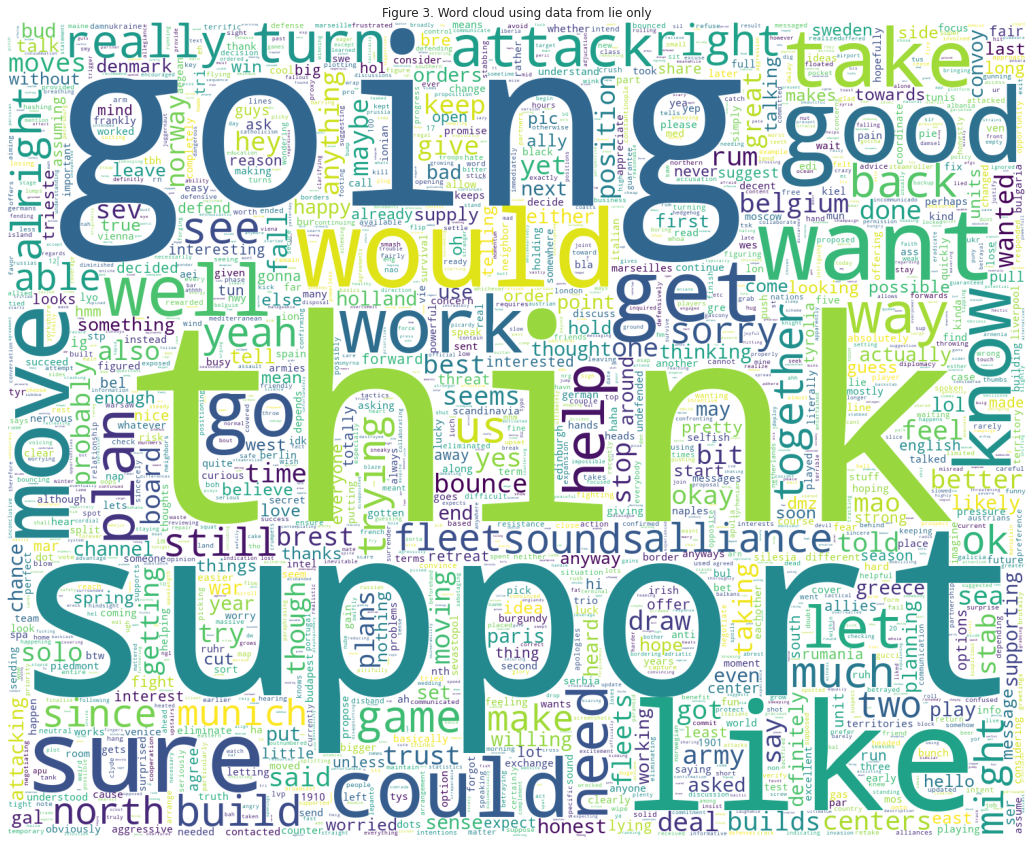

In [ ]:
v_f = TfidfVectorizer(ngram_range=(1,1),stop_words=stop)
text_f = v_f.fit_transform(false['messages'])

tfidf_weights_f = [(word, text_f.getcol(idx).sum()) for word, idx in v_f.vocabulary_.items()]

w_f = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights_f))
plt.figure(figsize=(20,15))
plt.imshow(w_f)
plt.axis('off')
plt.title("Figure 3. Word cloud using data from lie only")
plt.savefig('wordcloud_lie.png')


## Distribution Comparison

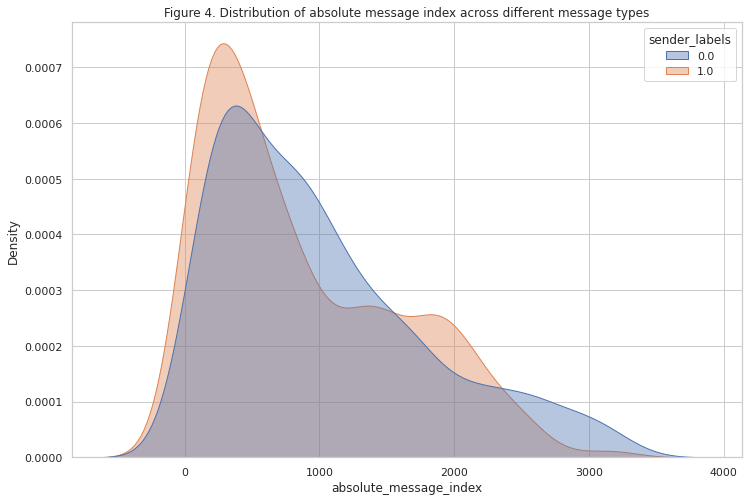

In [ ]:
plt.rcParams["figure.figsize"]=12,8

# set seaborn whitegrid theme
sns.set(style="whitegrid")

# Without transparency
sns.kdeplot(data=combined, x="absolute_message_index", hue="sender_labels", fill=True, common_norm=False, alpha=0.4)
plt.title("Figure 4. Distribution of absolute message index across different message types")
plt.show()

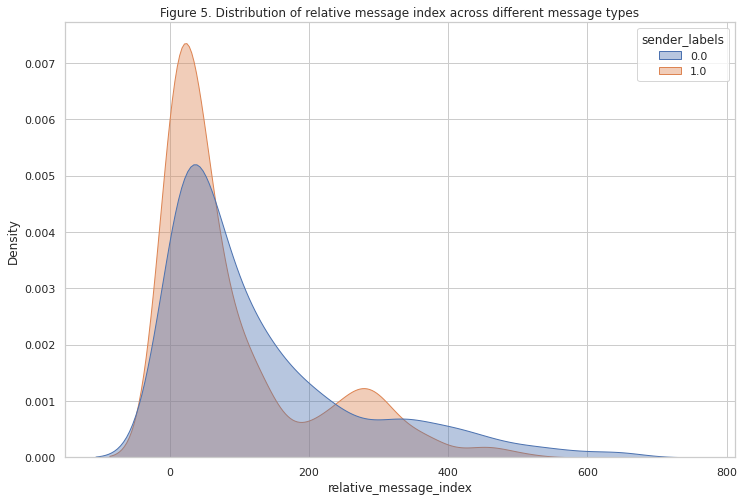

In [ ]:
plt.rcParams["figure.figsize"]=12,8

# set seaborn whitegrid theme
sns.set(style="whitegrid")

# Without transparency
sns.kdeplot(data=combined, x="relative_message_index", hue="sender_labels", fill=True, common_norm=False, alpha=0.4)
plt.title("Figure 5. Distribution of relative message index across different message types")
plt.show()

# Predictive Modeling

## Splitting features and target

In [ ]:
import numpy as np

input = combined.sample(frac=1)

X_train = input.drop(columns=['sender_labels'])
X_train_array = X_train.to_numpy()
#X_train_array
input['label'] = np.where(input['sender_labels'] == False, 1, 0)
curr_trans = input.drop(columns=['sender_labels'])
curr_trans

Y_train = curr_trans['label']
Y_train_array = Y_train.to_numpy()

input.head()
#Y_train_array



01   02   03   05   10  100   11   12   13   14  ...  \
707   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1606  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
431   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1389  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
726   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

      words_greater_six_count       TTR  pronoun_count  adjective_count  \
707                       1.0  0.950000            1.0              2.0   
1606                     14.0  0.670886            6.0              3.0   
431                       2.0  1.000000            0.0              2.0   
1389                      0.0  1.000000            0.0              2.0   
726                       1.0  1.000000            2.0              2.0   

      noun_count  verb_count  conjuction_count  preposition_count  \
707          3.0         7.0               1.0                2.0   
1606        20.0        21.0               3.0               10.0   
431          4.0         3.0               0.0                1.0   
1389         3.0         3.0               0.0                1.0   
726          3.0         2.0               1.0                2.0   

      adverb_count  label  
707            3.0      1  
1606           5.0      0  
431            0.0      1  
1389           1.0      0  
726            0.0      1  

[5 rows x 2985 columns]

## Logistic Regression

### Testing logistic regression model performance via cross validation

In [ ]:
from sklearn.metrics import average_precision_score as a_p_s
log_reg = LogisticRegression(penalty='l2',C = 50, solver='liblinear')
k_folds = KFold(n_splits = 5)
scores = cross_val_score(log_reg, X_train_array, Y_train_array, cv = k_folds)
precision = cross_val_score(log_reg, X_train_array, Y_train_array, cv = k_folds, scoring="precision_macro")

print('Cross-Validation precision Scores', precision)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation precision Scores [0.59432803 0.63062771 0.55187498 0.62241662 0.60547329]
Cross-Validation Accuracy Scores [0.59459459 0.63063063 0.55120482 0.62048193 0.60542169]


In [ ]:
scores = pd.Series(scores)
print(' Cross-Validation Accuracy Scores Min', scores.min(),'\n Cross-Validation Accuracy Scores Mean',scores.mean(),'\n Cross-Validation Accuracy Scores Max',scores.max())
precision = pd.Series(precision)
print(' Cross-Validation Precision Scores Min', precision.min(),'\n Cross-Validation Precision Scores Mean',precision.mean(),'\n Cross-Validation Precision Scores Max',precision.max())

 Cross-Validation Accuracy Scores Min 0.5512048192771084 
 Cross-Validation Accuracy Scores Mean 0.6004667317920329 
 Cross-Validation Accuracy Scores Max 0.6306306306306306
 Cross-Validation Precision Scores Min 0.5518749773115039 
 Cross-Validation Precision Scores Mean 0.600944125120289 
 Cross-Validation Precision Scores Max 0.6306277056277056


### Testing logistic regression model performance on the training set

In [ ]:
log_reg.fit(X_train_array, Y_train_array)
Y_hat = log_reg.predict(X_train_array)
accuracy = accuracy_score(Y_train_array, Y_hat)
print ('Regularized logistic regression, accuracy on training set:', accuracy)

Regularized logistic regression, accuracy on training set: 0.9813477737665464


## Naive Bayes

### Testing naive bayes classifier via cross validation

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import KFold, cross_val_score
nb = GaussianNB()
k_folds = KFold(n_splits = 5)
scores = cross_val_score(nb, X_train_array, Y_train_array, cv = k_folds)
precision = cross_val_score(nb, X_train_array, Y_train_array, cv = k_folds, scoring="precision_macro")
print('Cross-Validation precision Scores', precision)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation precision Scores [0.50065359 0.4983871  0.48558827 0.53941638 0.53608735]
Cross-Validation Accuracy Scores [0.5015015  0.4984985  0.48493976 0.53915663 0.53614458]


In [ ]:
from sklearn.model_selection import cross_val_predict
scores = pd.Series(scores)
print(' Cross-Validation Accuracy Scores Min', scores.min(),'\n Cross-Validation Accuracy Scores Mean',scores.mean(),'\n Cross-Validation Accuracy Scores Max',scores.max())
precision = pd.Series(precision)
print(' Cross-Validation Precision Scores Min', precision.min(),'\n Cross-Validation Precision Scores Mean',precision.mean(),'\n Cross-Validation Precision Scores Max',precision.max())



 Cross-Validation Accuracy Scores Min 0.48493975903614456 
 Cross-Validation Accuracy Scores Mean 0.5120481927710844 
 Cross-Validation Accuracy Scores Max 0.5391566265060241
 Cross-Validation Precision Scores Min 0.48558826732493554 
 Cross-Validation Precision Scores Mean 0.5120265374630597 
 Cross-Validation Precision Scores Max 0.5394163763066202


### Testing naive bayes classifier on training set

In [ ]:
nb.fit(X_train_array, Y_train_array)
Y_hat = nb.predict(X_train_array)
accuracy = accuracy_score(Y_train_array, Y_hat)
print ('naive bayes classifier, accuracy on training set:', accuracy)

naive bayes classifier, accuracy on training set: 0.8971119133574007


## Support Vector Machine

### Testing support vector classifier via cross validation

In [ ]:
from sklearn.svm import LinearSVC
SVC = LinearSVC(C=55, dual = False)
k_folds = KFold(n_splits = 5)
scores = cross_val_score(SVC, X_train_array, Y_train_array, cv = k_folds)
precision = cross_val_score(SVC, X_train_array, Y_train_array, cv = k_folds, scoring="precision_macro")
print('Cross-Validation precision Scores', precision)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation precision Scores [0.58834327 0.6066532  0.52777072 0.61732099 0.58436034]
Cross-Validation Accuracy Scores [0.58858859 0.60660661 0.52710843 0.61445783 0.58433735]


In [ ]:
scores = pd.Series(scores)
print(' Cross-Validation Accuracy Scores Min', scores.min(),'\n Cross-Validation Accuracy Scores Mean',scores.mean(),'\n Cross-Validation Accuracy Scores Max',scores.max())
precision = pd.Series(precision)
print(' Cross-Validation Precision Scores Min', precision.min(),'\n Cross-Validation Precision Scores Mean',precision.mean(),'\n Cross-Validation Precision Scores Max',precision.max())

 Cross-Validation Accuracy Scores Min 0.5271084337349398 
 Cross-Validation Accuracy Scores Mean 0.5842197619306053 
 Cross-Validation Accuracy Scores Max 0.6144578313253012
 Cross-Validation Precision Scores Min 0.52777071913457 
 Cross-Validation Precision Scores Mean 0.5848897039383724 
 Cross-Validation Precision Scores Max 0.6173209908162891


### Testing support vector classifier on training set

In [ ]:
SVC.fit(X_train_array, Y_train_array)
Y_hat = SVC.predict(X_train_array)
accuracy = accuracy_score(Y_train_array, Y_hat)
print ('support vector classifier, accuracy on training set:', accuracy)

support vector classifier, accuracy on training set: 0.9861612515042117


## KNN

### Testing KNN via cross validation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
k_folds = KFold(n_splits = 5)
scores = cross_val_score(knn, X_train_array, Y_train_array, cv = k_folds)
precision = cross_val_score(knn, X_train_array, Y_train_array, cv = k_folds, scoring="precision_macro")
print('Cross-Validation precision Scores', precision)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation precision Scores [0.6280052  0.6006135  0.6104573  0.62010234 0.62980769]
Cross-Validation Accuracy Scores [0.62762763 0.6006006  0.61144578 0.61746988 0.62951807]


In [ ]:
scores = pd.Series(scores)
print(' Cross-Validation Accuracy Scores Min', scores.min(),'\n Cross-Validation Accuracy Scores Mean',scores.mean(),'\n Cross-Validation Accuracy Scores Max',scores.max())
precision = pd.Series(precision)
print(' Cross-Validation Precision Scores Min', precision.min(),'\n Cross-Validation Precision Scores Mean',precision.mean(),'\n Cross-Validation Precision Scores Max',precision.max())

 Cross-Validation Accuracy Scores Min 0.6006006006006006 
 Cross-Validation Accuracy Scores Mean 0.6173323926335974 
 Cross-Validation Accuracy Scores Max 0.6295180722891566
 Cross-Validation Precision Scores Min 0.6006134969325153 
 Cross-Validation Precision Scores Mean 0.6177972058558228 
 Cross-Validation Precision Scores Max 0.6298076923076923


### Testing KNN on training set

In [ ]:
knn.fit(X_train_array, Y_train_array)
Y_hat = knn.predict(X_train_array)
accuracy = accuracy_score(Y_train_array, Y_hat)
print ('KNN, accuracy on training set:', accuracy)

KNN, accuracy on training set: 0.7996389891696751
